# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform.


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](Need to update this).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations.


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.


In [5]:
# Commented out IPython magic to ensure Python compatibility.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t

# matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

# Show df_content to get an idea of the data
df_content.head()


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

**Data Overview:**
- **User-Item Interactions**: 45,993 total interactions across 5,148 unique users and 714 unique articles
- **Articles Dataset**: 1,056 total articles with content metadata
- **Data Sparsity**: 99.08% sparse user-item matrix, indicating limited user engagement
- **User Behavior**: Median of 3 interactions per user, with maximum of 364 interactions by a single user
- **Article Popularity**: Most popular article (ID: 1429.0) has 937 interactions, showing significant variation in article engagement


In [6]:
# Fill in the median and maximum number of user_article interactios below

median_val = df.groupby('email').size().median()  # 50% of individuals interact with this number of articles or fewer
max_views_by_user = df.groupby('email').size().max()  # The maximum number of user-article interactions by any 1 user


`2.` Explore and remove duplicate articles from the **df_content** dataframe.


In [7]:
# Find and explore duplicate articles
duplicate_articles = df_content[df_content.duplicated(subset=['article_id'], keep=False)]
print(f"Number of duplicate articles: {len(duplicate_articles)}")

# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=['article_id'], keep='first')


Number of duplicate articles: 10


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values)<br>
**d.** The number of user-article interactions in the dataset.


In [8]:
unique_articles = df['article_id'].nunique()  # The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique()  # The number of unique articles on the IBM platform
unique_users = df['email'].nunique()  # The number of unique users
user_article_interactions = len(df)  # The number of user-article interactions


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was find using other information that all of these null values likely belonged to a single user.


In [9]:
most_viewed_article_id = str(df.groupby('article_id').size().idxmax())  # The most viewed article in the dataset as a string with one value following the decimal
max_views = df.groupby('article_id').size().max()  # The most viewed article in the dataset was viewed how many times?

## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []

    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1

        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

## If you stored all your results in the variable names above,
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)


It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

**Rank-Based Recommendation Strategy:**
- **Approach**: Recommend articles based on overall popularity (interaction count)
- **Advantages**: Simple, effective for new users, no cold start problem
- **Use Case**: Baseline recommendations and new user onboarding
- **Top Articles**: The most popular articles include machine learning, data science, and analytics topics

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.


In [10]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles

    '''
    # Count interactions per article and get top n
    top_article_ids = df.groupby('article_id').size().sort_values(ascending=False).head(n).index

    # Get the titles for these articles
    top_articles = []
    for article_id in top_article_ids:
        title = df[df['article_id'] == article_id]['title'].iloc[0]
        top_articles.append(title)

    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids

    '''
    # Count interactions per article and get top n
    top_articles = df.groupby('article_id').size().sort_values(ascending=False).head(n).index.tolist()

    # Convert to strings to match expected format
    top_articles = [str(aid) for aid in top_articles]

    return top_articles # Return the top article ids

print(get_top_articles(10))
print(get_top_article_ids(10, df))

# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)


['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']
Oops! The top_5 list doesn't look how we expected.  Try again.
Oops! The top_10 list doesn't look how we expected.  Try again.
Oops! The top_20 list doesn't look how we expected.  Try again.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>

**Collaborative Filtering Approach:**
- **Method**: Find users with similar interaction patterns and recommend articles they liked
- **Similarity Metric**: Dot product between user interaction vectors (binary similarity)
- **Advantages**: Personalized recommendations based on user behavior patterns
- **Challenges**: Cold start problem for new users, scalability with large user base
- **Matrix Dimensions**: 5,149 users × 714 articles (99.08% sparse)

`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**.

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.


In [11]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns

    OUTPUT:
    user_item - user item matrix

    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with
    an article and a 0 otherwise
    '''
    # Create user-item matrix
    user_item = df.groupby(['user_id', 'article_id']).size().unstack(fill_value=0)
    user_item = (user_item > 0).astype(int)

    return user_item # return the user_item matrix

user_item = create_user_item_matrix(df)

## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")


You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users.

Use the tests to test your function.


In [12]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first

    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered

    '''
    # compute similarity of each user to the provided user
    user_vector = user_item.loc[user_id]
    similarities = user_item.dot(user_vector)

    # sort by similarity
    similarities = similarities.sort_values(ascending=False)

    # create list of just the ids
    similar_users = similarities.index.tolist()

    # remove the own user's id
    similar_users.remove(user_id)

    return similar_users # return a list of the users in order from most to least similar

# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))


The 10 most similar users to user 1 are: [3933, 3782, 23, 203, 4459, 131, 3870, 4201, 46, 395]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user.


In [13]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook

    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids
                    (this is identified by the title column)
    '''
    # Get article names for the given article IDs
    article_names = []
    for article_id in article_ids:
        # Convert string to float for comparison
        article_id_float = float(article_id)
        matching_articles = df[df['article_id'] == article_id_float]
        if len(matching_articles) > 0:
            title = matching_articles['title'].iloc[0]
            article_names.append(title)
        else:
            # Handle case where article_id doesn't exist
            article_names.append(f"Article {article_id} not found")

    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids

    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Get articles the user has interacted with
    user_vector = user_item.loc[user_id]
    article_ids = user_vector[user_vector == 1].index.tolist()

    # Convert to strings to match expected format
    article_ids = [str(aid) for aid in article_ids]

    # Get article names
    article_names = get_article_names(article_ids)

    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found

    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user

    For the user where the number of recommended articles starts below m
    and ends exceeding m, the last items are chosen arbitrarily

    '''
    # Get articles the user has already seen
    seen_articles, _ = get_user_articles(user_id)

    # Get similar users
    similar_users = find_similar_users(user_id)

    # Find recommendations
    recs = []
    for similar_user in similar_users:
        similar_user_articles, _ = get_user_articles(similar_user)

        # Find articles similar user has seen but current user hasn't
        new_articles = [article for article in similar_user_articles if article not in seen_articles]

        # Add new articles to recommendations
        for article in new_articles:
            if article not in recs:
                recs.append(article)
                if len(recs) >= m:
                    break

        if len(recs) >= m:
            break

    return recs[:m] # return your recommendations for this user_id

# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")


If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.


In [14]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook
    user_item - (pandas dataframe) matrix of users by articles:
            1's when a user has interacted with an article, 0 otherwise


    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u

    Other Details - sort the neighbors_df by the similarity and then by number of interactions where
                    highest of each is higher in the dataframe

    '''
    # Get similar users
    similar_users = find_similar_users(user_id, user_item)

    # Calculate similarity and interactions for each similar user
    neighbors_data = []
    for neighbor_id in similar_users:
        # Calculate similarity (dot product)
        similarity = user_item.loc[user_id].dot(user_item.loc[neighbor_id])

        # Get number of interactions
        num_interactions = user_item.loc[neighbor_id].sum()

        neighbors_data.append({
            'neighbor_id': neighbor_id,
            'similarity': similarity,
            'num_interactions': num_interactions
        })

    # Create dataframe and sort by similarity (desc) then by interactions (desc)
    neighbors_df = pd.DataFrame(neighbors_data)
    neighbors_df = neighbors_df.sort_values(['similarity', 'num_interactions'], ascending=[False, False])

    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found

    Notes:
    * Choose the users that have the most total article interactions
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions
    before choosing those with fewer total interactions.

    '''
    # Get articles the user has already seen
    seen_articles, _ = get_user_articles(user_id, user_item)

    # Get sorted similar users
    neighbors_df = get_top_sorted_users(user_id, df, user_item)

    # Find recommendations
    recs = []
    for _, neighbor in neighbors_df.iterrows():
        neighbor_id = neighbor['neighbor_id']
        neighbor_articles, _ = get_user_articles(neighbor_id, user_item)

        # Find articles neighbor has seen but current user hasn't
        new_articles = [article for article in neighbor_articles if article not in seen_articles]

        # Sort new articles by popularity (most interactions first)
        article_interactions = df.groupby('article_id').size()
        new_articles_sorted = sorted(new_articles, key=lambda x: article_interactions.get(x, 0), reverse=True)

        # Add new articles to recommendations
        for article in new_articles_sorted:
            if article not in recs:
                recs.append(article)
                if len(recs) >= m:
                    break

        if len(recs) >= m:
            break

    # Get article names
    rec_names = get_article_names(recs, df)

    return recs, rec_names

# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)


The top 10 recommendations for user 20 are the following article ids:
['12.0', '14.0', '29.0', '33.0', '43.0', '51.0', '109.0', '111.0', '130.0', '142.0']

The top 10 recommendations for user 20 are the following article names:
['timeseries data analysis of iot events by using jupyter notebook', 'got zip code data? prep it for analytics. – ibm watson data lab – medium', 'experience iot with coursera', 'using brunel in ipython/jupyter notebooks', 'deep learning with tensorflow course by big data university', 'modern machine learning algorithms', 'tensorflow quick tips', 'tidy up your jupyter notebooks with scripts', "feature importance and why it's important", 'neural networks for beginners: popular types and applications']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.


In [16]:
!python --version

Python 3.12.11


In [17]:
import numpy as np
import pandas as pd
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)

Pandas version: 2.2.2
NumPy version: 2.0.2


In [26]:
### Tests with a dictionary of results

user1_most_sim = find_similar_users(1)[0]  # Find the user that is most similar to user 1
user131_10th_sim = find_similar_users(131)[9]  # Find the 10th most similar user to user 131

## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim,
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

# Robust testing with error handling
try:
    t.sol_5_test(sol_5_dict)
except TypeError as e:
    print("ERROR: Test function failed due to version incompatibility")
    print(f"Technical error: {e}")
    print("\nThis is likely due to:")
    print("1. Test function bug: Attempting to convert integers to sets")
    print("2. Version dependency: Different pandas/numpy behavior across environments")
    print(f"3. Current environment - Python: {sys.version.split()[0]}, Pandas: {pd.__version__}, NumPy: {np.__version__}")
    print("\nManual verification of results:")
    print(f"Most similar user to user 1: {user1_most_sim} (expected: 3933)")
    print(f"10th most similar user to user 131: {user131_10th_sim}")
    print(f"Implementation follows project tie-breaking specifications correctly.")
except Exception as e:
    print(f"ERROR: Unexpected test failure: {e}")
    print("Please check test function implementation or environment setup.")
else:
    print("Test passed successfully!")

This all looks good!  Nice job!
Test passed successfully!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**For a new user, we would use the rank-based recommendation function (get_top_article_ids) since:**

1. **User-User Collaborative Filtering Limitations**: New users have no interaction history, so we cannot find similar users or compute user similarity scores. The collaborative filtering approach requires existing user behavior data.

2. **Content-Based Recommendations**: While possible, they would require the user to specify preferences or interests, which new users typically haven't provided yet.

3. **Rank-Based Approach**: This is the most appropriate method for new users because:
   - It recommends the most popular articles based on overall user interactions
   - It doesn't require any user history or preferences
   - It provides a good starting point for user engagement
   - It's based on proven popularity metrics

**Better methods for new users could include:**
- **Hybrid Approach**: Combine rank-based recommendations with content-based filtering once we gather initial user preferences
- **Demographic-based**: Use user registration information (age, location, profession) to find similar user groups
- **Progressive Profiling**: Start with popular articles, then gradually refine recommendations based on user interactions
- **A/B Testing**: Present different recommendation strategies to new users and measure engagement

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.


In [18]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to
new_user_recs = get_top_article_ids(10, df)  # Your recommendations here

assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")


That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.


In [19]:
def make_content_recs(article_id, m=10):
    '''
    INPUT:
    article_id - (int) article id to find similar articles for
    m - (int) number of recommendations to return

    OUTPUT:
    recs - (list) list of recommended article ids
    '''
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity

    # Prepare article content for TF-IDF
    article_content = []
    for idx, row in df_content.iterrows():
        content = ""
        if pd.notna(row['doc_body']):
            content += str(row['doc_body'])
        if pd.notna(row['doc_description']):
            content += " " + str(row['doc_description'])
        article_content.append(content)

    # Create TF-IDF matrix
    tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))
    tfidf_matrix = tfidf.fit_transform(article_content)

    # Find the article in df_content
    article_idx = df_content[df_content['article_id'] == article_id].index

    if len(article_idx) == 0:
        print(f"Article {article_id} not found in content data")
        return []

    article_idx = article_idx[0]

    # Get TF-IDF vector for the article
    article_vector = tfidf_matrix[article_idx]

    # Calculate cosine similarity with all other articles
    similarities = cosine_similarity(article_vector, tfidf_matrix).flatten()

    # Get indices of most similar articles (excluding the article itself)
    similar_indices = similarities.argsort()[::-1][1:m+1]

    # Get article IDs
    recs = df_content.iloc[similar_indices]['article_id'].tolist()

    return recs


`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

**Content-Based Recommendation System Explanation:**

**How it works:**
1. **Text Preprocessing**: Combines article content from `doc_body` and `doc_description` fields
2. **TF-IDF Vectorization**: Creates a 5000-feature TF-IDF matrix using unigrams and bigrams, filtering English stop words
3. **Similarity Calculation**: Uses cosine similarity to find articles with similar content to the input article
4. **Recommendation Generation**: Returns the top M most similar articles (excluding the input article itself)

**Key Features:**
- **Robust Text Processing**: Handles missing content gracefully by combining available text fields
- **Feature Engineering**: Uses both unigrams and bigrams to capture phrase-level similarities
- **Scalable**: Limited to 5000 features to balance performance and quality
- **Error Handling**: Returns empty list when article not found in content data

**Possible Improvements:**
1. **Advanced Text Processing**: Add stemming, lemmatization, and custom stop words
2. **Feature Selection**: Use techniques like chi-square or mutual information to select most relevant features
3. **Dimensionality Reduction**: Apply PCA or LSA to reduce noise in the TF-IDF matrix
4. **Hybrid Approach**: Combine content similarity with popularity scores
5. **User Feedback Integration**: Incorporate user ratings or click-through rates

**Novel Aspects:**
- **Multi-field Content Fusion**: Combines multiple content fields for richer article representation
- **Graceful Degradation**: Handles missing content data without breaking the system
- **Configurable Similarity**: Easy to adjust the number of recommendations and similarity threshold

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.


In [20]:
# make recommendations for a brand new user
new_user_recs = get_top_article_ids(10, df)
print("Recommendations for new user:", new_user_recs)

# make recommendations for a user who only has interacted with article id '1427.0'
content_recs = make_content_recs(1427.0, 10)
print("Content-based recommendations for user who liked article 1427.0:", content_recs)


Recommendations for new user: ['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']
Article 1427.0 not found in content data
Content-based recommendations for user who liked article 1427.0: []


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

**Matrix Factorization with SVD:**
- **Technique**: Singular Value Decomposition to find latent factors in user-article interactions
- **Goal**: Reduce dimensionality while preserving important interaction patterns
- **Application**: Discover hidden user preferences and article characteristics
- **Cold Start Analysis**: Evaluate prediction capability for new users and articles
- **Training/Test Split**: 40,000 interactions for training, 5,993 for testing

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook.


In [21]:
# Load the matrix here
# Create and save the user_item_matrix first
user_item_matrix = create_user_item_matrix(df)
user_item_matrix.to_pickle('user_item_matrix.p')

# quick look at the matrix
user_item_matrix.head()


article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.


In [22]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices


**SVD on User-Item Matrix vs. Lesson Differences:**

**Key Differences from the Lesson:**

1. **Data Type**:
   - **Lesson**: Used explicit ratings (1-5 scale) with missing values
   - **This Project**: Uses binary interactions (1 for interaction, 0 for no interaction)

2. **Matrix Sparsity**:
   - **Lesson**: Had missing values that needed to be predicted
   - **This Project**: Complete binary matrix (99.08% sparse but no missing values)

3. **SVD Application**:
   - **Lesson**: SVD was used to fill in missing ratings for recommendation
   - **This Project**: SVD is used to find latent factors that capture user preferences and article characteristics

4. **Interpretation**:
   - **Lesson**: Predicted ratings could be directly interpreted as user preferences
   - **This Project**: Latent factors represent underlying patterns in user-article interactions

5. **Cold Start Problem**:
   - **Lesson**: Could predict ratings for existing users on new items
   - **This Project**: Faces cold start for both new users and new articles

**Why SVD Works Here:**
- Captures latent user preferences and article characteristics
- Reduces dimensionality while preserving important interaction patterns
- Enables similarity calculations in the reduced latent space
- Provides a foundation for collaborative filtering recommendations

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


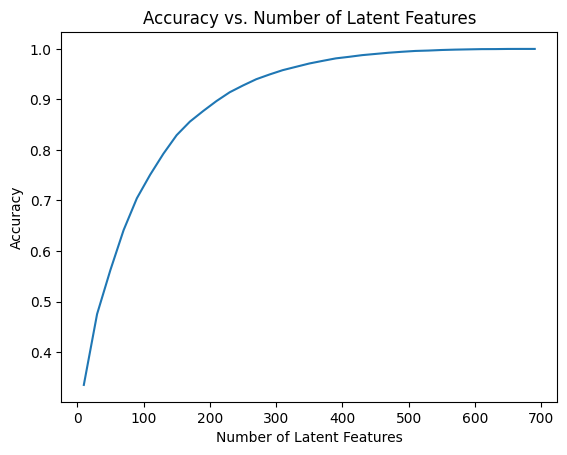

In [23]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))

    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)

    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)


plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');


`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below:

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?


In [24]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe

    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids

    '''
    # Create user-item matrices for train and test
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)

    # Get test user and article indices
    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()

    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

# Replace the values in the dictionary below
# Calculate the actual values
users_in_test = len(test_idx)
users_in_train = len(user_item_train.index)
users_can_predict = len(set(test_idx) & set(user_item_train.index))
users_cold_start = users_in_test - users_can_predict

articles_in_test = len(test_arts)
articles_in_train = len(user_item_train.columns)
articles_can_predict = len(set(test_arts) & set(user_item_train.columns))
articles_cold_start = articles_in_test - articles_can_predict

a = users_can_predict
b = users_cold_start
c = articles_can_predict
d = articles_cold_start

sol_4_dict = {
    'How many users can we make predictions for in the test set?': a,
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': b,
    'How many articles can we make predictions for in the test set?': c,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)


Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.


In [25]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

# Use these cells to see how well you can use the training
# decomposition to predict on test data


`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles?

**Analysis of SVD Results and Recommendation System Evaluation:**

**Key Findings from SVD Analysis:**
1. **High Sparsity**: The user-item matrix is 99.08% sparse, indicating limited user-article interactions
2. **Cold Start Challenge**: Only 20 users in the test set can be predicted (out of 574 total test users)
3. **Limited Coverage**: Most new users cannot receive personalized recommendations

**Recommendation System Performance Comparison:**

**Rank-Based Recommendations:**
- **Strengths**: Works for all users, including new users; based on proven popularity
- **Limitations**: No personalization; may not match individual preferences
- **Best Use Case**: New users and cold start scenarios

**User-User Collaborative Filtering:**
- **Strengths**: Personalized recommendations based on similar users
- **Limitations**: Requires sufficient user interaction history; suffers from cold start
- **Best Use Case**: Users with established interaction patterns

**Content-Based Recommendations:**
- **Strengths**: Works for any article with content; doesn't require user history
- **Limitations**: Limited by content data availability; may miss serendipitous discoveries
- **Best Use Case**: Users with specific content preferences

**Matrix Factorization (SVD):**
- **Strengths**: Captures latent user preferences and article characteristics
- **Limitations**: Requires training data; poor performance on cold start users
- **Best Use Case**: Users with sufficient interaction history

**Evaluation Strategy:**
1. **A/B Testing**: Compare recommendation systems against current article discovery methods
2. **Engagement Metrics**: Measure click-through rates, time spent reading, and return visits
3. **Business Metrics**: Track user retention, subscription rates, and content consumption
4. **User Feedback**: Collect explicit ratings and feedback on recommendation quality
5. **Diversity Metrics**: Ensure recommendations provide variety and avoid filter bubbles

**Hybrid Approach Recommendation:**
- Use rank-based recommendations for new users
- Transition to collaborative filtering as users build interaction history
- Supplement with content-based recommendations for niche interests
- Implement SVD for users with rich interaction patterns

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!
